# cache_ext plotting

## Setup

In [6]:
%load_ext autoreload
%autoreload 2
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bench_lib
import bench_plot_lib as plot_lib

importlib.reload(bench_lib)
importlib.reload(plot_lib)

GiB = 2**30

SYS_NAME = "cache_ext"
RESULTS_DIR = "../results/cache_ext_mon_pc/2025_11_18_06h46m31/"
FIGURES_DIR = "../figures/"
POLICY_DIR = "../policies/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Create FIGURES_DIR
os.makedirs(FIGURES_DIR, exist_ok=True)

In [8]:
def iops_select_fn(r):
    return r["jobs"][0]["read"]["iops"]


def leveldb_throughput_avg_select_fn(r):
    return r["throughput_avg"]


def leveldb_read_throughput_avg_select_fn(r):
    return r["read_throughput_avg"]


def leveldb_scan_throughput_avg_select_fn(r):
    return r["scan_throughput_avg"]


def leveldb_latency_p99_select_fn(r):
    return (
        r["latency_p99"] / 10**6
        if r["latency_p99"] != 0
        else r["scan_latency_p99"] / 10**6
    )


def leveldb_read_latency_p99_select_fn(r):
    return r["read_latency_p99"] / 10**6


def leveldb_scan_latency_p99_select_fn(r):
    return r["scan_latency_p99"] / 10**6


def filter_cgroup_results(results, cgroup_name):
    return [r for r in results if r.config["cgroup_name"] == cgroup_name]


def filter_cache_ext_results(results):
    return filter_cgroup_results(results, bench_lib.DEFAULT_CACHE_EXT_CGROUP)


def add_config_field(results, key, value):
    for r in results:
        if key not in r.config:
            r.config[key] = value

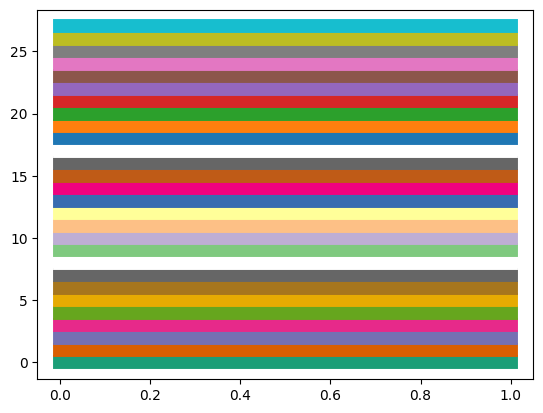

In [9]:
dark_colors = plt.colormaps["Dark2"].colors
accent_colors = plt.colormaps["Accent"].colors
tab10_colors = plt.colormaps["tab10"].colors

white=((1, 1, 1), )

colors = dark_colors + white + accent_colors + white + tab10_colors

for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, linewidth=10)

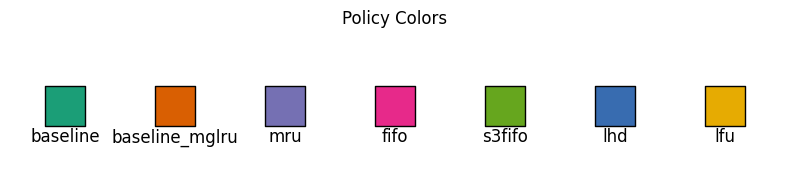

In [10]:
policy_color = {
    "baseline": dark_colors[0],
    "baseline_mglru": dark_colors[1],
    "mru": dark_colors[2],
    "fifo": dark_colors[3],
    "s3fifo": dark_colors[4],
    "lhd": accent_colors[4],
    "lfu": dark_colors[5],
}

plt.figure(figsize=(8, 2))
n = len(policy_color)
for i, (policy, color) in enumerate(policy_color.items()):
    plt.scatter(i, 0, color=color, s=800, marker='s', edgecolors='k')
    plt.text(i, -0.3, policy, ha='center', va='top', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.title("Policy Colors")
plt.xlim(-0.5, n - 0.5)
plt.ylim(-1, 1)
plt.box(False)
plt.tight_layout()
plt.show()

## Twitter Traces (Figure 7)

In [43]:
# Twitter results

clusters = [17, 18, 24, 34, 52]
results = []
mglru_results = []
for cluster in clusters:
    results += bench_lib.parse_results_file(
        RESULTS_DIR + "twitter_traces_%d_results.json" % cluster,
        bench_lib.BenchResults,
    )
    mglru_results += bench_lib.parse_results_file(
        RESULTS_DIR + "twitter_traces_%d_results_mglru.json" % cluster,
        bench_lib.BenchResults,
    )

cache_ext_results = filter_cache_ext_results(results)
baseline_results = filter_cgroup_results(results, bench_lib.DEFAULT_BASELINE_CGROUP)

add_config_field(cache_ext_results, "mglru", False)
add_config_field(baseline_results, "mglru", False)
add_config_field(mglru_results, "mglru", True)

config_matches = [
    {
        "name": "leveldb_twitter_trace_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size_pct", [10], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)

cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "cache_ext_sampling.out",
    ],
    cache_ext_matches,
)

# new_config_matches = []
# for config in config_matches:
#     if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
#         new_config = config.copy()
#         new_config_matches.append(new_config)
#     else:
#         # for policy_loader in ["cache_ext_s3fifo.out"]:
#         for policy_loader in ["cache_ext_s3fifo.out", "cache_ext_sampling.out", "cache_ext_lhd.out"]:
#             new_config = config.copy()
#             new_config["policy_loader"] = policy_loader
#             new_config_matches.append(new_config)
# config_matches = new_config_matches


bench_types = ["twitter_cluster%d_bench" % cluster for cluster in clusters]
bench_type_to_group = {
    "twitter_cluster%d_bench" % cluster: "Cluster %d" % cluster for cluster in clusters
}

s3fifo_matches = [cm for cm in cache_ext_matches if "s3fifo" in cm["policy_loader"]]
lhd_matches = [cm for cm in cache_ext_matches if "lhd" in cm["policy_loader"]]
sampling_matches = [cm for cm in cache_ext_matches if "sampling" in cm["policy_loader"]]

config_matches = baseline_matches + s3fifo_matches + lhd_matches + sampling_matches


def name_func(config):
    if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
        if config["mglru"]:
            return "MGLRU (Linux)"
        else:
            return "Default (Linux)"
        # return "Baseline (%d%% cache)" % config["cgroup_size_pct"]
    elif "s3fifo" in config["policy_loader"].lower():
        return "S3-FIFO (%s)" % SYS_NAME
    elif "sampling" in config["policy_loader"].lower():
        return "LFU (%s)" % SYS_NAME
    elif "lhd" in config["policy_loader"].lower():
        return "LHD (%s)" % SYS_NAME


twitter_policies = ["baseline", "baseline_mglru", "s3fifo", "lhd", "lfu"]
twitter_colors = [policy_color[tp] for tp in twitter_policies]

plot_lib.bench_plot_groupped_results(
    config_matches,
    results + mglru_results,
    colors=twitter_colors,
    bench_types=bench_types,
    bench_type_to_group=bench_type_to_group,
    filename=FIGURES_DIR + "leveldb_twitter_traces_throughput.pdf",
    bar_width=0.5,
    show_measurements=True,
    y_label="Throughput (ops/sec)",
    name_func=name_func,
    result_select_fn=leveldb_throughput_avg_select_fn,
    normalize_per_group=False,
    legend_loc="best",
    label_fontsize=20,
    fontsize=12,
    measurement_fontsize=10,
    measurement_offset=300,
    ylimit=40000,
)

{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster17_bench'}
[31085.24, 27382.37, 28894.97]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster18_bench'}
[31633.61, 31569.64, 29361.98]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster24_bench'}
[18212.45, 18630.1, 19734.23]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster34_bench'}
[5000.52, 5021.63, 5191.91]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster52_bench'}
[14697.22, 13202.22, 10502.58]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup

<Figure size 640x480 with 0 Axes>

## Filesearch Benchmark (Figure 9)

In [12]:
def make_name(config) -> str:
    # These names must match the values in your config JSONs
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"

    cgroup_name = config["cgroup_name"]
    damon_mode = config.get("damon_mode")
    mglru = config.get("mglru", False)

    prefix = ""
    suffix = ""

    # 1. Prefix
    if damon_mode:
        # Converts "very_aggressive" to "Very Aggressive"
        damon_label = damon_mode.replace("_", " ").title()
        prefix = f"DAMON {damon_label}"
    elif mglru:
        prefix = "MGLRU"
    elif cgroup_name == DEFAULT_CACHE_EXT_CGROUP:
        prefix = "MRU"
    elif cgroup_name == DEFAULT_BASELINE_CGROUP:
        prefix = "Default"
    else:
        prefix = "<unknown>"

    # Suffix
    if cgroup_name == DEFAULT_BASELINE_CGROUP:
        suffix = "(Linux)"
    elif cgroup_name == DEFAULT_CACHE_EXT_CGROUP:
        suffix = "(cache_ext)"
    else:
        suffix = "(<unknown>)"

    return f"{prefix} {suffix}"


filesearch_results = bench_lib.parse_results_file(
    RESULTS_DIR + "filesearch_results.json", bench_lib.BenchResults
)

mglru_filesearch_results = bench_lib.parse_results_file(
    RESULTS_DIR + "filesearch_results_mglru.json", bench_lib.BenchResults
)

# damon_normal_results = bench_lib.parse_results_file(
#     RESULTS_DIR + "filesearch_results_damon_1.json", bench_lib.BenchResults
# )

# damon_aggressive_results = bench_lib.parse_results_file(
#     RESULTS_DIR + "filesearch_results_damon_2.json", bench_lib.BenchResults
# )

# damon_very_aggressive_results = bench_lib.parse_results_file(
#     RESULTS_DIR + "filesearch_results_damon_3.json", bench_lib.BenchResults
# )

cache_ext_filesearch_results = filter_cache_ext_results(filesearch_results)
baseline_filesearch_results = filter_cgroup_results(
    filesearch_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_filesearch_results, "mglru", False)
add_config_field(cache_ext_filesearch_results, "mglru", False)
add_config_field(mglru_filesearch_results, "mglru", True)
# add_config_field(damon_normal_results, "mglru", False)
# add_config_field(damon_aggressive_results, "mglru", False)
# add_config_field(damon_very_aggressive_results, "mglru", False)

add_config_field(baseline_filesearch_results, "damon_mode", None)
add_config_field(cache_ext_filesearch_results, "damon_mode", None)
add_config_field(mglru_filesearch_results, "damon_mode", None)
# add_config_field(damon_normal_results, "damon_mode", "normal")
# add_config_field(damon_aggressive_results, "damon_mode", "aggressive")
# add_config_field(damon_very_aggressive_results, "damon_mode", "very_aggressive")

filesearch_results = (
    baseline_filesearch_results
    + cache_ext_filesearch_results
    + mglru_filesearch_results
    # + damon_normal_results
    # + damon_aggressive_results
    # + damon_very_aggressive_results
)

base_config = {"name": "filesearch_benchmark", "cgroup_size": 1 * GiB}

config_matches = [
    # Default (under baseline)
    {**base_config,
     "cgroup_name": bench_lib.DEFAULT_BASELINE_CGROUP,
     "mglru": False,
     "damon_mode": None},
    
    # MGLRU (under baseline)
    {**base_config,
     "cgroup_name": bench_lib.DEFAULT_BASELINE_CGROUP,
     "mglru": True,
     "damon_mode": None},
     
    # MRU (under cache_ext)
    {**base_config,
     "cgroup_name": bench_lib.DEFAULT_CACHE_EXT_CGROUP,
     "mglru": False,
     "damon_mode": None},
     
    # # DAMON Normal (under baseline)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_BASELINE_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "normal"},
     
    # # DAMON Aggressive (under baseline)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_BASELINE_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "aggressive"},
     
    # # DAMON Very Aggressive (under baseline)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_BASELINE_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "very_aggressive"},

    # # DAMON Normal (under cache_ext)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_CACHE_EXT_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "normal"},
     
    # # DAMON Aggressive (under cache_ext)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_CACHE_EXT_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "aggressive"},
     
    # # DAMON Very Aggressive (under cache_ext)
    # {**base_config,
    #  "cgroup_name": bench_lib.DEFAULT_CACHE_EXT_CGROUP,
    #  "mglru": False,
    #  "damon_mode": "very_aggressive"},
]


def runtime_select_fn(r):
    return r["runtime_sec"]


colors = plt.colormaps["Dark2"].colors + plt.colormaps["tab10"].colors

plot_lib.bench_plot_groupped_results(
    config_matches,
    filesearch_results,
    y_label="Runtime (s)",
    show_measurements=False,
    colors=colors[0:3],
    bench_types=["filesearch"],
    result_select_fn=runtime_select_fn,
    bench_type_to_group={"filesearch": "File Search"},
    filename=FIGURES_DIR + "filesearch_results.pdf",
    label_fontsize=16,
    fontsize=20,
    legend_fontsize=16,
    ylimit=150,
    name_func=make_name,
)

{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': False, 'damon_mode': None, 'benchmark': 'filesearch'}
[103.32976770401001, 73.48813939094543, 72.68160891532898]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': True, 'damon_mode': None, 'benchmark': 'filesearch'}
[76.14097118377686, 66.79796171188354, 70.5677080154419]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'cache_ext_test', 'mglru': False, 'damon_mode': None, 'benchmark': 'filesearch'}
[36.44632935523987, 37.3030047416687, 36.54116892814636]
[[np.float64(83.16650533676147)], [np.float64(71.16888030370076)], [np.float64(36.763501008351646)]]
[-1.  0.  1.]
[-1.]
[0.]
[1.]


<Figure size 640x480 with 0 Axes>

## YCSB Benchmark (Figure 6)

In [50]:
# YCSB results

def make_name(config) -> str:
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"
    if config["cgroup_name"] == DEFAULT_BASELINE_CGROUP:
        mglru = config.get("mglru", False)
        if mglru:
            return "MGLRU (Linux)"
        return "Default (Linux)"
    elif config["cgroup_name"] == DEFAULT_CACHE_EXT_CGROUP:
        if "s3fifo" in config["policy_loader"]:
            return "S3-FIFO (%s)" % SYS_NAME
        elif "sampling" in config["policy_loader"]:
            return "LFU (%s)" % SYS_NAME
        elif "lhd" in config["policy_loader"]:
            return "LHD (%s)" % SYS_NAME
        elif "fifo" in config["policy_loader"]:
            return "FIFO (%s)" % SYS_NAME
        elif "mru" in config["policy_loader"]:
            return "MRU (%s)" % SYS_NAME
    return "<unknown>"


ycsb_results = bench_lib.parse_results_file(
    RESULTS_DIR + "ycsb_results.json", bench_lib.BenchResults
)

mglru_ycsb_results = bench_lib.parse_results_file(
    RESULTS_DIR + "ycsb_results_mglru.json", bench_lib.BenchResults
)
cache_ext_ycsb_results = filter_cache_ext_results(ycsb_results)
baseline_ycsb_results = filter_cgroup_results(
    ycsb_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_ycsb_results, "mglru", False)
add_config_field(mglru_ycsb_results, "mglru", True)
add_config_field(cache_ext_ycsb_results, "mglru", False)

ycsb_results = baseline_ycsb_results + cache_ext_ycsb_results + mglru_ycsb_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

print(config_matches)

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "cache_ext_sampling.out",
        "cache_ext_fifo.out",
        "cache_ext_mru.out",
    ],
    cache_ext_matches,
)


print(cache_ext_matches)

mru_matches = [cm for cm in cache_ext_matches if "mru" in cm["policy_loader"]]
fifo_matches = [cm for cm in cache_ext_matches if "_fifo" in cm["policy_loader"]]
s3fifo_matches = [cm for cm in cache_ext_matches if "s3fifo" in cm["policy_loader"]]
lhd_matches = [cm for cm in cache_ext_matches if "lhd" in cm["policy_loader"]]
sampling_matches = [cm for cm in cache_ext_matches if "sampling" in cm["policy_loader"]]

matches = (
    baseline_matches
    + mru_matches
    + fifo_matches
    + s3fifo_matches
    + lhd_matches
    + sampling_matches
)

# Make a colors list for the policies
ycsb_colors = [ c for p, c in policy_color.items() ]

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    name_func=make_name,
    colors=ycsb_colors,  # "salmon", "maroon", "limegreen", "goldenrod"],
    bench_types=[
        "ycsb_a",
        "ycsb_b",
        "ycsb_c",
        "ycsb_d",
        "ycsb_e",
        "ycsb_f",
        "uniform",
        "uniform_read_write",
    ],
    # ["uniform", "uniform_read_write"],
    filename=FIGURES_DIR + "leveldb_ycsb_throughput.pdf",
    bar_width=0.5,
    show_measurements=True,
    result_select_fn=leveldb_throughput_avg_select_fn,
    ylimit=2000,
    text_center_list=[3],
    measurement_offset=15,
    measurement_fontsize=6.5,
    legend_fontsize=8,
    fontsize=11,
    label_fontsize=18,
)

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    colors=ycsb_colors,
    name_func=make_name,
    bench_types=[
        "ycsb_a",
        "ycsb_b",
        "ycsb_c",
        "ycsb_d",
        "ycsb_e",
        "ycsb_f",
        "uniform",
        "uniform_read_write",
    ],
    filename=FIGURES_DIR + "leveldb_ycsb_latency.pdf",
    bar_width=0.5,
    legend_fontsize=8,
    result_select_fn=leveldb_latency_p99_select_fn,
    show_measurements=False,
    y_label="P99 Latency (ms)",
    fontsize=11,
    label_fontsize=18,
)

[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test'}]
[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_lhd.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_s3fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_sampling.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_mru.out'}]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_a'}
[1125.47, 1404.8, 1402.53]


<Figure size 640x480 with 0 Axes>

## GET-SCAN Benchmark (FIgure 8)

In [34]:
# Mixed GET-SCAN results

get_scan_results = bench_lib.parse_results_file(
    RESULTS_DIR + "get_scan_results.json", bench_lib.BenchResults
)
mglru_get_scan_results = bench_lib.parse_results_file(
    RESULTS_DIR + "get_scan_results_mglru.json", bench_lib.BenchResults
)
cache_ext_get_scan_results = filter_cache_ext_results(get_scan_results)
baseline_get_scan_results = filter_cgroup_results(
    get_scan_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

add_config_field(baseline_get_scan_results, "mglru", False)
add_config_field(mglru_get_scan_results, "mglru", True)
add_config_field(cache_ext_get_scan_results, "mglru", False)
get_scan_results = (
    baseline_get_scan_results
    + cache_ext_get_scan_results
    + mglru_get_scan_results
)

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option(
    "cgroup_name",
    [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP],
    config_matches,
)

# Get the baseline config and generate two more:
# - One with "fadvise": "NOREUSE"
# - One with "fadvise": "DONTNEED"
# - One with "fadvise": "SEQUENTIAL"

baseline_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP
]
cache_ext_matches = [
    cm
    for cm in config_matches
    if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP
]

baseline_matches = bench_lib.add_config_option("mglru", [False], baseline_matches)
baseline_matches = bench_lib.add_config_option(
    "fadvise", ["", "NOREUSE", "DONTNEED", "SEQUENTIAL"], baseline_matches
)
baseline_mglru_match = baseline_matches[0].copy()
baseline_mglru_match["mglru"] = True
baseline_matches.append(baseline_mglru_match)

config_matches = baseline_matches + cache_ext_matches


baseline_idx = 0
cache_ext_idx = -1

config_matches[baseline_idx]["iteration"] = 1
# throughput_baseline = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# latency_baseline = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# throughput_cache_ext = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# latency_cache_ext = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
throughput_baseline = np.mean(
    [
        leveldb_read_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
latency_baseline = np.mean(
    [
        leveldb_read_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
throughput_cache_ext = np.mean(
    [
        leveldb_read_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)
latency_cache_ext = np.mean(
    [
        leveldb_read_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)

# Calculate improvement over baseline
throughput_improvement = throughput_cache_ext / throughput_baseline
latency_improvement = (latency_baseline - latency_cache_ext) / latency_baseline * 100
print(f"Throughput improvement: {throughput_improvement:.2f}x")
print(f"Latency reduction: {latency_improvement:.2f}%")
print(
    "Latency: baseline %.2fms, cache_ext %.2fms" % (latency_baseline, latency_cache_ext)
)

# scan_throughput_baseline = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_latency_baseline = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_throughput_cache_ext = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# scan_latency_cache_ext = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
scan_throughput_baseline = np.mean(
    [
        leveldb_scan_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
scan_latency_baseline = np.mean(
    [
        leveldb_scan_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[baseline_idx]
        )
    ]
)
scan_throughput_cache_ext = np.mean(
    [
        leveldb_scan_throughput_avg_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)
scan_latency_cache_ext = np.mean(
    [
        leveldb_scan_latency_p99_select_fn(r.results)
        for r in bench_lib.results_select(
            get_scan_results, config_matches[cache_ext_idx]
        )
    ]
)

scan_throughput_improvement = scan_throughput_cache_ext / scan_throughput_baseline
scan_latency_improvement = (
    (scan_latency_baseline - scan_latency_cache_ext) / scan_latency_baseline * 100
)
print(f"Scan throughput improvement: {scan_throughput_improvement:.2f}x")
print(f"Scan latency reduction: {scan_latency_improvement:.2f}%")
print(
    "Scan latency: baseline %.2fms, cache_ext %.2fms"
    % (scan_latency_baseline, scan_latency_cache_ext)
)

colorsb = plt.colormaps["tab20b"].colors
colorsc = plt.colormaps["Dark2"].colors
colors = list(colorsb[:4]) + [colorsc[0]] + [colorsc[1]]
print(colors)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_throughput_avg_select_fn,
    colors=colors,
    # colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=1100,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc="upper right",
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_throughput_avg_select_fn,
    colors=colors,
    # colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=40,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc="upper right",
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc="best",
    ylimit=140,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc="best",
    ylimit=1200,
)

Throughput improvement: 1.08x
Latency reduction: -2.38%
Latency: baseline 51.25ms, cache_ext 52.47ms
Scan throughput improvement: 0.73x
Scan latency reduction: -149.57%
Scan latency: baseline 201.79ms, cache_ext 503.60ms
[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686), (0.3215686274509804, 0.32941176470588235, 0.6392156862745098), (0.4196078431372549, 0.43137254901960786, 0.8117647058823529), (0.611764705882353, 0.6196078431372549, 0.8705882352941177), (0.10588235294117647, 0.6196078431372549, 0.4666666666666667), (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': '', 'iteration': 1, 'benchmark': 'mixed_get_scan'}
[437.19]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'NOREUSE', 'benchmark': 'mixed_get_scan'}
[491.33, 516.74, 472.81]
{'name': 'leveldb_benchmark', 'cgroup_si

<Figure size 640x480 with 0 Axes>

## Policy Lines of Code (Table 3)

Note that the Admission filter LoC are added manually, as they are not part of the policy files.


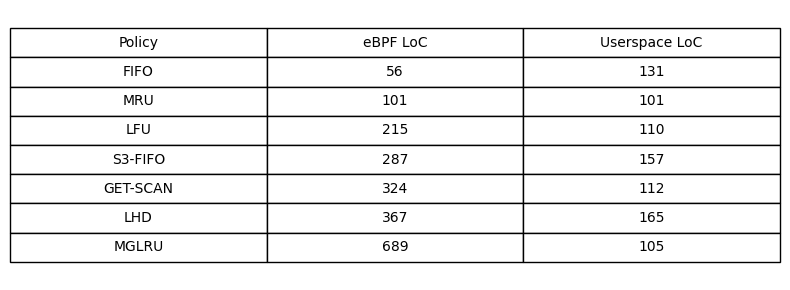

In [16]:
# Lines of code required for each policy

def c_file_is_loc(line: str):
    line = line.strip()
    if line.startswith("//") or line.startswith("/*") or line == "":
        return False
    return True


def c_file_count_loc(file_name: str):
    if not file_name.endswith(".c"):
        raise ValueError("File must be a C file")
    with open(POLICY_DIR + file_name, "r") as f:
        lines = f.readlines()
    loc_count = 0
    for line in lines:
        if c_file_is_loc(line):
            loc_count += 1
    return loc_count


mru_loc_count = c_file_count_loc("cache_ext_mru.bpf.c")
lfu_loc_count = c_file_count_loc("cache_ext_sampling.bpf.c")
get_scan_loc_count = c_file_count_loc("cache_ext_get_scan.bpf.c")
lhd_loc_count = c_file_count_loc("cache_ext_lhd.bpf.c")
s3fifo_loc_count = c_file_count_loc("cache_ext_s3fifo.bpf.c")
fifo_loc_count = c_file_count_loc("cache_ext_fifo.bpf.c")
mglru_loc_count = c_file_count_loc("cache_ext_mglru.bpf.c")

mru_user_loc_count = c_file_count_loc("cache_ext_mru.c")
lfu_user_loc_count = c_file_count_loc("cache_ext_sampling.c")
get_user_scan_loc_count = c_file_count_loc("cache_ext_get_scan.c")
lhd_user_loc_count = c_file_count_loc("cache_ext_lhd.c")
s3fifo_user_loc_count = c_file_count_loc("cache_ext_s3fifo.c")
fifo_user_loc_count = c_file_count_loc("cache_ext_fifo.c")
mglru_user_loc_count = c_file_count_loc("cache_ext_mglru.c")

# Put the LOC data in a table
table_data = [
    ["MRU", mru_loc_count, mru_user_loc_count],
    ["LFU", lfu_loc_count, lfu_user_loc_count],
    ["GET-SCAN", get_scan_loc_count, get_user_scan_loc_count],
    ["LHD", lhd_loc_count, lhd_user_loc_count],
    ["S3-FIFO", s3fifo_loc_count, s3fifo_user_loc_count],
    ["FIFO", fifo_loc_count, fifo_user_loc_count],
    ["MGLRU", mglru_loc_count, mglru_user_loc_count],
]

# Sort by LOC count
table_data.sort(key=lambda x: x[1])
# table_data_userspace.sort(key=lambda x: x[1])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(
    cellText=table_data,
    colLabels=["Policy", "eBPF LoC", "Userspace LoC"],
    cellLoc="center",
    loc="center",
)

print("Note that the Admission filter LoC are added manually, as they are not part of the policy files.")

table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Policy", "eBPF LoC", "Userspace LoC"])
df.to_latex(
    FIGURES_DIR + "loc_table.tex",
    index=False,
    caption="Lines of code required for each policy presented.",
    label="tab:loc-per-policy",
)

In [ ]:
# Kernel lines of code

verifier = 1 + 3 + 86
core_cache_ext = 105 + 57 + 27 + 156 + 235
kfuncs = 748
page_cache = 26 + 8 + 175
cgroup = 80
per_cgroup = 5 + 3 + 1 + 6 + 200 + 3
libbpf = 73

print("Verifier: %d" % verifier)
print("Core Cache Ext: %d" % core_cache_ext)
print("Kfuncs: %d" % kfuncs)
print("Page Cache: %d" % page_cache)
print("Cgroup: %d" % cgroup)
print("Per Cgroup: %d" % per_cgroup)
print("Libbpf: %d" % libbpf)

total = verifier + core_cache_ext + kfuncs + page_cache + cgroup + per_cgroup + libbpf
print("Total: %d" % total)

Verifier: 90
Core Cache Ext: 580
Kfuncs: 748
Page Cache: 209
Cgroup: 80
Per Cgroup: 218
Libbpf: 73
Total: 1998


## FIO Microbenchmark (Table 4)

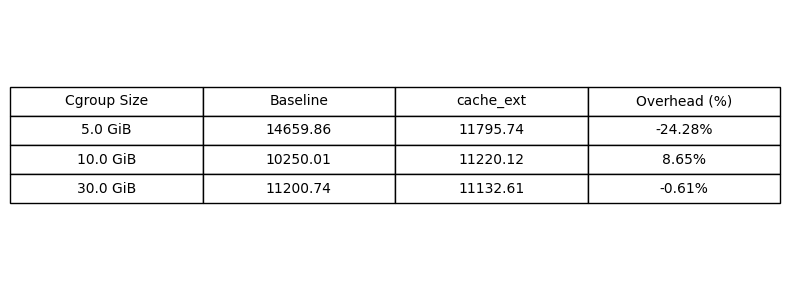

In [17]:
# fio results

fio_results = bench_lib.parse_results_file(
    RESULTS_DIR + "cpu_overhead_results.json", bench_lib.BenchResults
)

cache_ext_fio_results = filter_cache_ext_results(fio_results)
baseline_fio_results = filter_cgroup_results(
    fio_results, bench_lib.DEFAULT_BASELINE_CGROUP
)

cgroup_sizes = [5 * GiB, 10 * GiB, 30 * GiB]

def cpu_usage_per_iop_select_fn(r):
    return r["cpu_usage"] / iops_select_fn(r)

baseline_cpu_usage = {}
baseline_mglru_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
}

baseline_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(
        fio_results, baseline_config_match, cpu_usage_per_iop_select_fn
    )
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(
        fio_results, cache_ext_config_match, cpu_usage_per_iop_select_fn
    )
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) * 10**6

    cpu_usage_diff[cgroup_size] = (
        (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size])
        / cache_ext_cpu_usage[cgroup_size]
        * 100
    )

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage

table_data = [ 
    [
        f"{c / GiB} GiB",
        f"{baseline_cpu_usage[c]:.2f}",
        f"{cache_ext_cpu_usage[c]:.2f}",
        f"{cpu_usage_diff[c]:.2f}%"
    ]
    for c in cgroup_sizes
]

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(
    cellText=table_data,
    colLabels=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"],
    cellLoc="center",
    loc="center",
)
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(
    table_data,
    columns=["Cgroup Size", "Baseline", SYS_NAME, "Overhead (%)"],
)
df.to_latex(
    FIGURES_DIR + "cpu_overhead_table.tex",
    index=False,
    caption="fio microbenchmark results to measure CPU overhead of \name per IO operation.",
    label="tab:eval-cpu-overhead",
)

## Per-Cgroup Benchmark (Figure 10)

[(np.float64(1440.2), np.float64(36.0)), (np.float64(2730.7233333333334), np.float64(25.0)), (np.float64(2256.8633333333332), np.float64(53.666666666666664)), (np.float64(2366.1299999999997), np.float64(50.0))]
Split configuration throughput improvement over baseline: 64.29%
Split configuration RG iters improvement over baseline: 38.89%


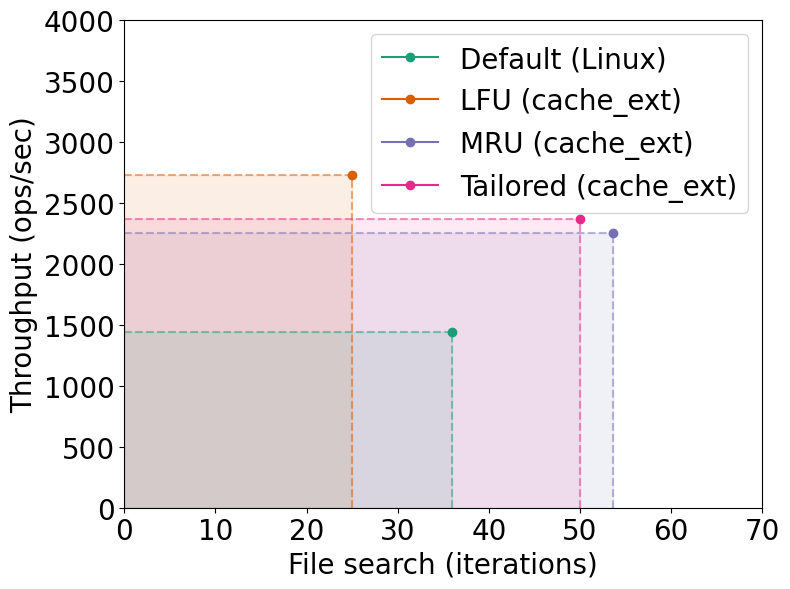

In [52]:
baseline_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_baseline_results.json", bench_lib.BenchResults
)
both_lfu_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_both_lfu_results.json", bench_lib.BenchResults
)
both_mru_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_both_mru_results.json", bench_lib.BenchResults
)
split_results = bench_lib.parse_results_file(
    RESULTS_DIR + "per_cgroup_split_results.json", bench_lib.BenchResults
)

print(baseline_results[0].results)


# Compute the average of the results["throughput_avg"] and results["rg_iters"] fields for each set of results
def avg_throughput_and_rg_iters(results):
    throughput_avg = np.mean([r.results["throughput_avg"] for r in results])
    rg_iters = np.mean([r.results["rg_iters"] for r in results])
    return throughput_avg, rg_iters


labels = [
    "Default (Linux)",
    "LFU (%s)" % SYS_NAME,
    "MRU (%s)" % SYS_NAME,
    "Tailored (%s)" % SYS_NAME,
]
results = [baseline_results, both_lfu_results, both_mru_results, split_results]
avg_throughputs_and_iters = [avg_throughput_and_rg_iters(r) for r in results]
print(avg_throughputs_and_iters)

colors = plt.colormaps["Dark2"].colors[:4]

# Create a point plot using matplotlib, with throughput on the y-axis and RG iters on the x-axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the throughput and RG iters for each set of results
for i in range(len(results)):
    # Use colors from colors list
    ax.plot(
        avg_throughputs_and_iters[i][1],
        avg_throughputs_and_iters[i][0],
        marker="o",
        color=colors[i],
        label=labels[i],
    )

# Add dotted lines to each of the points from the x axis and y axis using appropriate colors
# Trim the lines after each point
for i in range(len(results)):
    ax.plot(
        [0, avg_throughputs_and_iters[i][1]],
        [avg_throughputs_and_iters[i][0], avg_throughputs_and_iters[i][0]],
        linestyle="--",
        color=colors[i],
        alpha=0.5,
    )
    ax.plot(
        [avg_throughputs_and_iters[i][1], avg_throughputs_and_iters[i][1]],
        [0, avg_throughputs_and_iters[i][0]],
        linestyle="--",
        color=colors[i],
        alpha=0.5,
    )

# Fill in the rectangles created by the lines in reverse order
for i in range(len(results) - 1, -1, -1):
    ax.fill_between(
        [0, avg_throughputs_and_iters[i][1]],
        0,
        avg_throughputs_and_iters[i][0],
        color=colors[i],
        alpha=0.1,
    )

# Set x-axis and y-axis to start at 0
ax.set_xlim(left=0, right=70)
ax.set_ylim(bottom=0, top=4000)

# Set tick fontsize
ax.tick_params(axis="both", which="major", labelsize=20)

# Add labels
ax.set_xlabel("File search (iterations)", fontsize=20)
ax.set_ylabel("Throughput (ops/sec)", fontsize=20)

# Add a legend
ax.legend(loc="upper right", fontsize=20)

# Save to PDF
plt.tight_layout()
plt.savefig(FIGURES_DIR + "per_cgroup.pdf")

# Print percent improvement of split configuration over baseline
baseline_throughput = avg_throughputs_and_iters[0][0]
split_throughput = avg_throughputs_and_iters[3][0]
improvement = (split_throughput - baseline_throughput) / baseline_throughput * 100
print(f"Split configuration throughput improvement over baseline: {improvement:.2f}%")

baseline_iters = avg_throughputs_and_iters[0][1]
split_iters = avg_throughputs_and_iters[3][1]
improvement = (split_iters - baseline_iters) / baseline_iters * 100
print(f"Split configuration RG iters improvement over baseline: {improvement:.2f}%")

# add_config_field(baseline_results, "type", 1)
# add_config_field(both_lfu_results, "type", 2)
# add_config_field(both_mru_results, "type", 3)
# add_config_field(split_results, "type", 4)

# results = baseline_results + both_lfu_results + both_mru_results + split_results

## MGLRU Overhead (Table 5)